In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tess_sip import SIP
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

%config InlineBackend.print_figure_kwargs={"facecolor" : "w"}

In [3]:
srs_tpfs = lk.search_targetpixelfile("WASP50", author="TESS-SPOC")
tpfs = srs_tpfs.download_all()
srs_tpfs

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 04,2018,TESS-SPOC,1800,382391899,0.0
1,TESS Sector 31,2020,TESS-SPOC,600,382391899,0.0


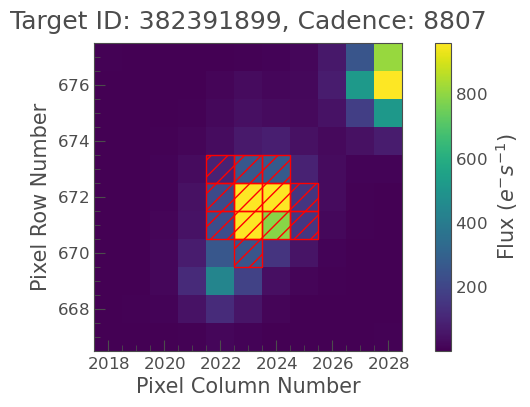

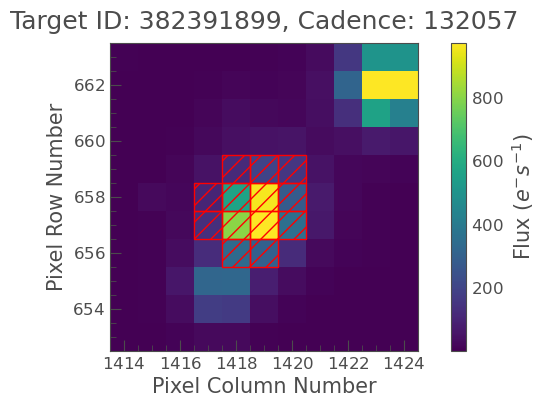

In [16]:
for tpf in tpfs:
    tpf.plot(aperture_mask="pipeline")
    plt.show()

In [12]:
srs_lcs = lk.search_lightcurve("WASP50", author="TESS-SPOC")
lcs = srs_lcs.download_all()
srs_lcs

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 04,2018,TESS-SPOC,1800,382391899,0.0
1,TESS Sector 31,2020,TESS-SPOC,600,382391899,0.0


In [10]:
def f_sp(T_0, T_sp, Delta_L):
    return (T_0**4 / (T_0**4 - T_sp**4)) * (1 - Delta_L)

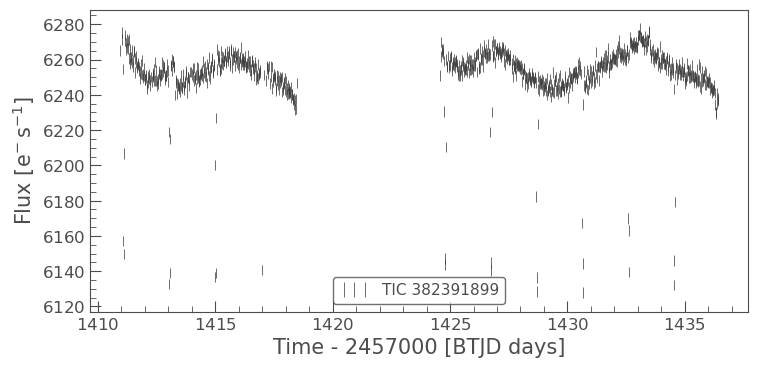

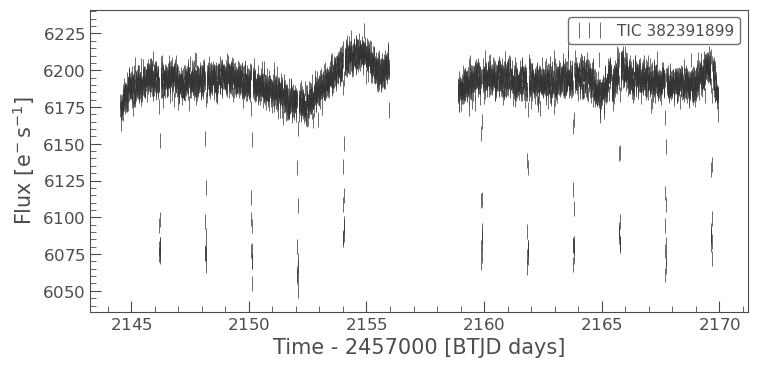

In [9]:
for lc in lcs:
    lc.errorbar()
    plt.show()

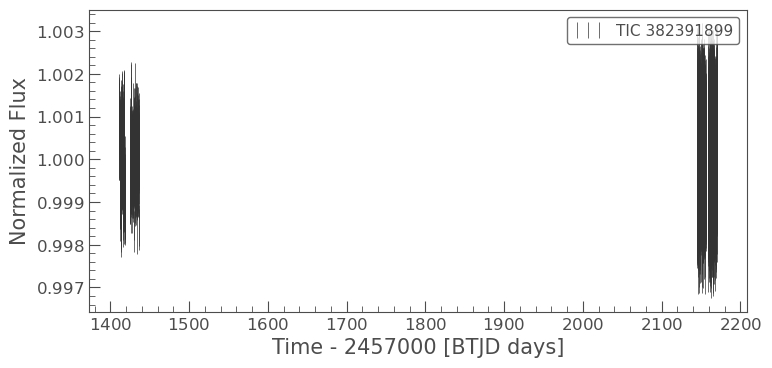

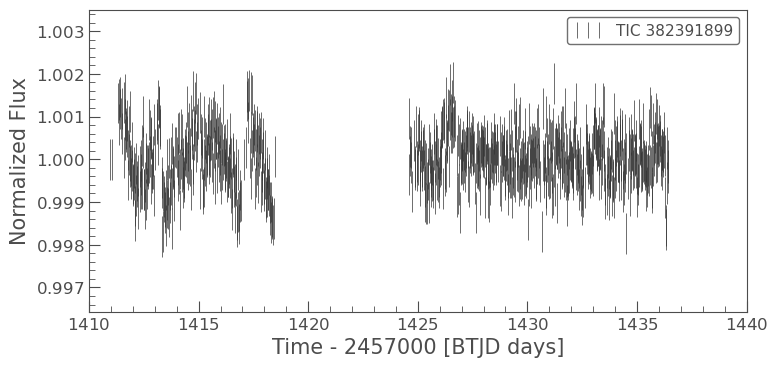

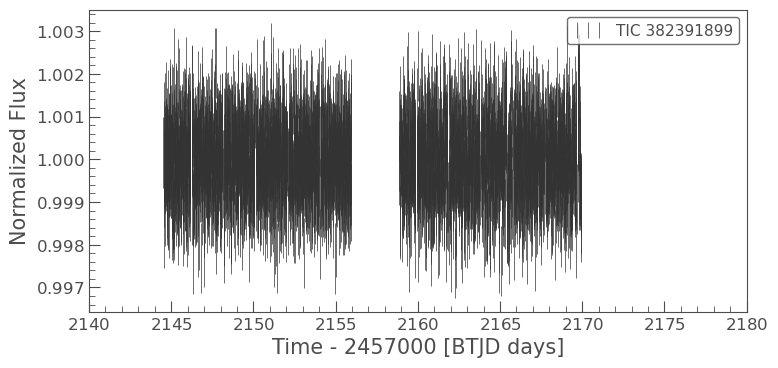

In [10]:
lc_combined = lcs.stitch(lambda x: x.remove_nans().flatten().remove_outliers(sigma=3.0).normalize())

ax = lc_combined.errorbar()
plt.show()

ax = lc_combined.errorbar()
ax.set_xlim(1_410, 1_440)
plt.show()

ax = lc_combined.errorbar()
ax.set_xlim(2_140, 2_180)
plt.show()

In [5]:
tpfs

TargetPixelFileCollection of 2 objects:
    0: TessTargetPixelFile(TICID: 382391899)
    1: TessTargetPixelFile(TICID: 382391899)

Lightcurve File Input


/home/mango/miniconda3/envs/WASP-50b/lib/python3.9/site-packages/lightkurve/lightcurve.py:1031: LightkurveWarning: The light curve appears to be zero-centered (median=1.39e+03 electron / s +/- 8.00e+03 electron / s); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  warnings.warn(
Running pixels in aperture: 100%|██████████| 100/100 [00:00<00:00, 192.56it/s]


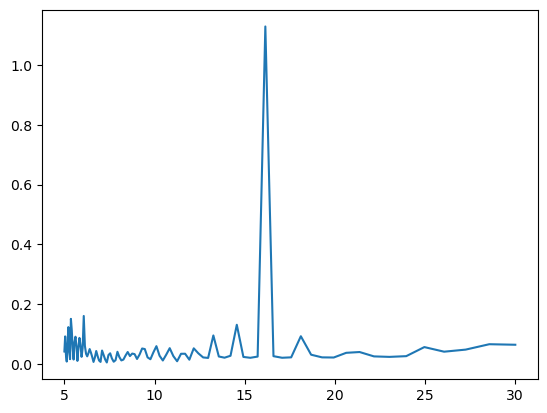

16.141304347826086


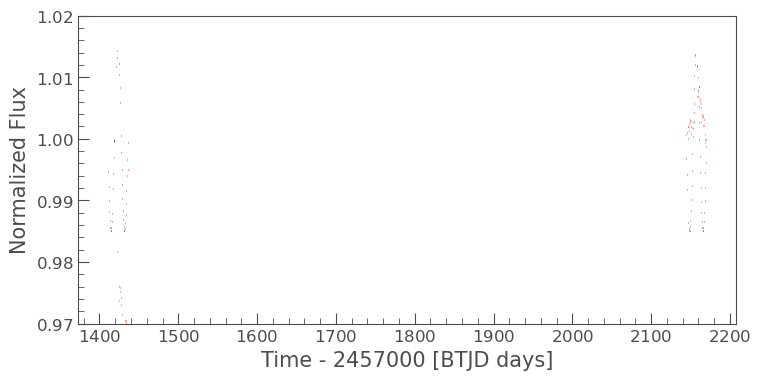

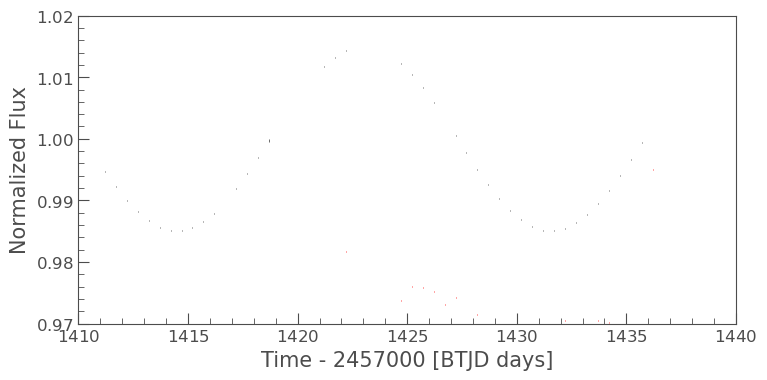

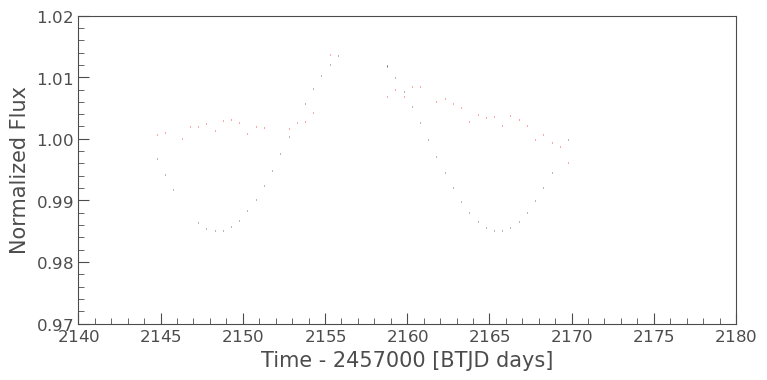

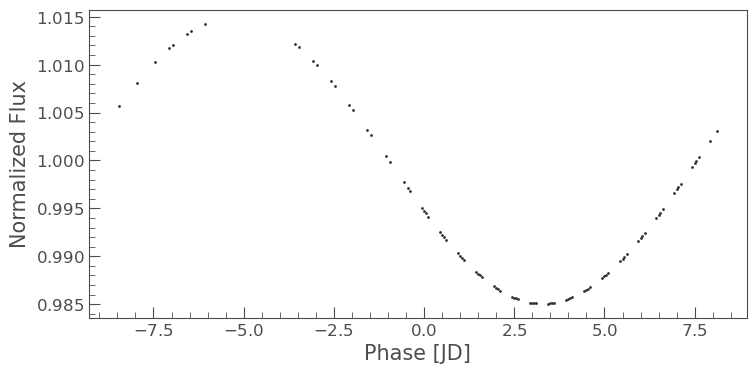

(0.0072806034432943085, 0.009152381522708851)

In [14]:
sip_kwargs = {
    "min_period": 5.0,
    "max_period": 30.0,
    "nperiods": 100,
    "bin_kwargs": {"time_bin_size": 12.0*u.hr.to("d")},
}

r = SIP(lcs, **sip_kwargs)

power_div = r["power"] / r["power_bkg"]
plt.plot(r["periods"], power_div)
plt.show()

P_max = r["periods"][np.argmax(power_div)]
print(P_max)

ax = r["corr_lc"].errorbar()
r["raw_lc"].errorbar(ax=ax, color="red")
ax.set_ylim(0.97, 1.02)
plt.show()

ax = r["corr_lc"].errorbar()
r["raw_lc"].errorbar(ax=ax, color="red")
ax.set_xlim(1_410, 1_440)
ax.set_ylim(0.97, 1.02)
plt.show()

ax = r["corr_lc"].errorbar()
r["raw_lc"].errorbar(ax=ax, color="red")
ax.set_xlim(2_140, 2_180)
ax.set_ylim(0.97, 1.02)
plt.show()

# pg = r["corr_lc"].to_periodogram(minimum_period=5, maximum_period=30)
# pg.period_at_max_power
phot_phase = r["corr_lc"].remove_nans().remove_outliers(sigma=3.0).fold(r["period_at_max_power"])
ax = phot_phase.scatter()
plt.show()
f = phot_phase.flux.value
T_0 = 5_520
Delta_L = np.min(f) / np.median(f)

f_sp(T_0, 2_200, Delta_L), f_sp(T_0, 3_800, Delta_L)